Notebook del modelo de árbol de decisión del dataframe de las peleas ponderadas

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/31
- **Propósito del código:** Árbol de clasificación para el dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** Además de intentar sacar el mejor modelo posible, tenemos como objetivo que variables tienen peso en el modelo.
- **Estado actual:** Perfeccionando.

In [3]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#No hay estudio de transformaciones *
#Se evaluan los modelos con accuracy en vez de f1-score (se explica el porque en la memoria) *
#Explica cada modelo un poco: que hace, porque lo usas *
#No hay estudio de selección de variables. Si es necesario hacer una selección indicar que algoritmo de selección de variables usar. *

In [4]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
from sklearn import tree  
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#los parquet ya están divididos entre train y test
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)
train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,10.302760,0.000000,12,5,0.24,0.1160,-0.475248,-3.16,0.80,-185.76
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,18.618225,14.838304,7,10,-0.12,-0.0364,0.081182,1.56,0.00,228.72
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,10.699383,1.382640,10,5,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.741553,8.765110,8,4,-0.76,-0.1868,0.000000,0.88,0.00,143.08
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,10.585655,4.242632,8,13,0.00,-0.0880,0.093856,-0.92,-0.40,188.52


In [6]:
ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)
test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.00,0.5864,0.3636,0.1200,0.4500,...,189.612060,8.036330e+01,25,9,0.40,0.2228,-0.307248,-0.36,0.0,-136.44
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,0.00,0.4824,0.6552,0.0800,0.0000,...,0.000000,0.000000e+00,6,5,0.36,-0.1728,0.133333,0.00,0.0,-61.20
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,0.00,0.4276,0.5056,0.2000,0.2792,...,139.896213,2.207734e-07,16,6,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.00,0.6544,0.4112,0.0000,0.0000,...,24.394312,0.000000e+00,8,4,0.60,0.2432,0.000000,0.40,0.0,16.88
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.36,0.24,0.6300,0.5844,0.7576,0.1200,...,322.872251,5.342818e+02,13,12,0.12,0.0456,0.130692,1.16,-0.8,5.28


TRANSFORMACIONES

No es necesario hacer transformaciones para hacer un árbol de decisión ya que estos pueden manejar los datos sin estos cambios.

SELECCIÓN DE VARIABLES

Tampoco es necesario hacer una selección de variables ya que los árboles de decisión no se ven afectados por diferencias en las magnitudes de las variables, además de que el propio árbol selecciona las características más relevantes de las variables.

AJUSTE DE HIPERPARÁMETROS

Para ajustar los parámetros hemos utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. Primero probamos a hacer un modelo con Grid Search.

In [7]:
def train_decision_tree_grid(X_train, y_train, X_test, y_test):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    tscv = TimeSeriesSplit(n_splits=5)


    # Definir modelo base
    dt = DecisionTreeClassifier(random_state=42)

    # Cuadrícula de hiperparámetros
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
        'max_depth': [3],  # Profundidad máxima del árbol
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
        'min_weight_fraction_leaf': [0.10, 0.12, 0.14],
        'splitter': ['best','random'],
        'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
        'max_features': [None, 'sqrt', 'log2']
    }
    

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring= f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_test)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Visualización del árbol
    plt.figure(figsize=(15, 8))
    plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return grid_search.best_estimator_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Mejores parámetros: {'class_weight': {0: np.float64(0.8897224306076519), 1: np.float64(1.1414821944177094)}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.12, 'splitter': 'best'}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.40      0.49       327
        True       0.49      0.69      0.57       267

    accuracy                           0.53       594
   macro avg       0.55      0.55      0.53       594
weighted avg       0.56      0.53      0.52       594



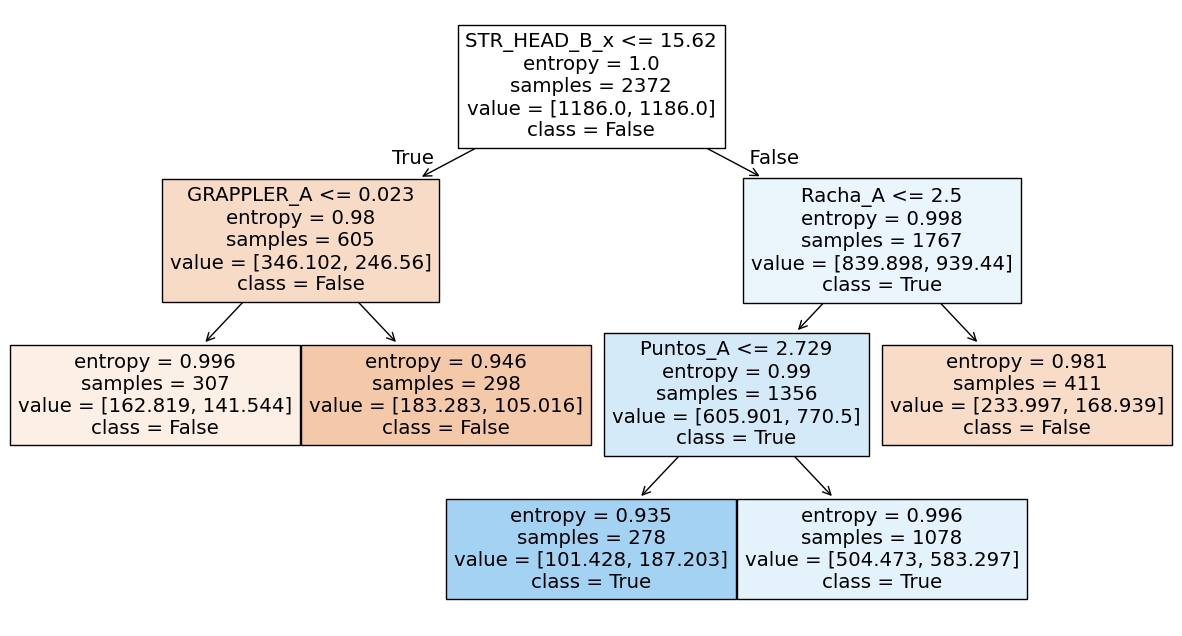

In [8]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"] #categóricas y variable respuesta

X_train = train.drop(columns=columnasQuitar)
y_train = train['WINNER']
X_test = test.drop(columns=columnasQuitar)
y_test = test['WINNER']


tree = train_decision_tree_grid(X_train, y_train, X_test, y_test)

Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.34335
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.09526
Variables con importancia en el modelo: Racha_A, Importancia: 0.37927
Variables con importancia en el modelo: Puntos_A, Importancia: 0.18212


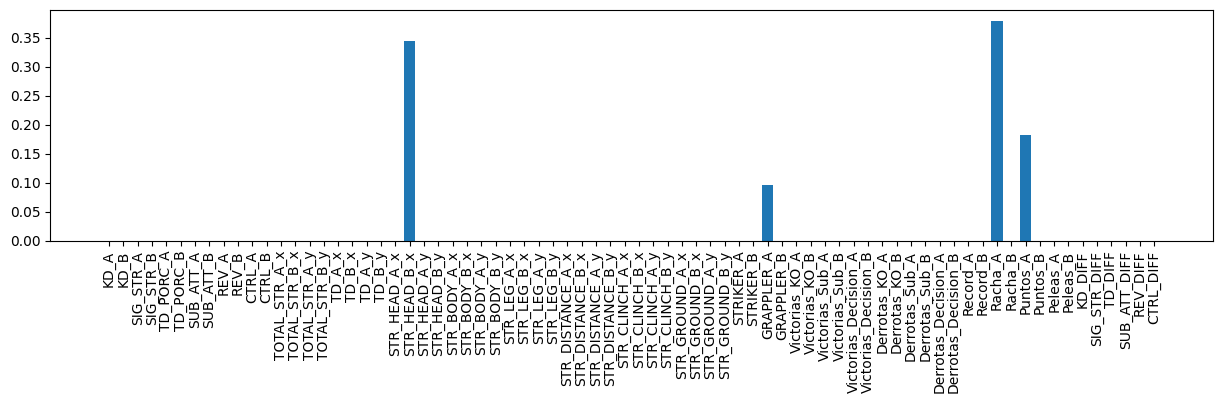

In [9]:
importance = tree.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

Como vemos el árbol con mejor f1_score tiene max_depth = 3, lo que hace que no haya muchas variables importantes ya que se usan pocas en el modelo.

In [10]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_test_pred = tree.predict(X_test)
y_test_prob = tree.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_prob)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
log_loss_test = log_loss(y_test,y_test_prob)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test, y_test_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.531986531986532
F1-Score: 0.5710
AUC-ROC: 0.5674
Precisión: 0.4856
Sensibilidad: 0.6929
Log-loss: 0.6847063263630556
[[131 196]
 [ 82 185]]


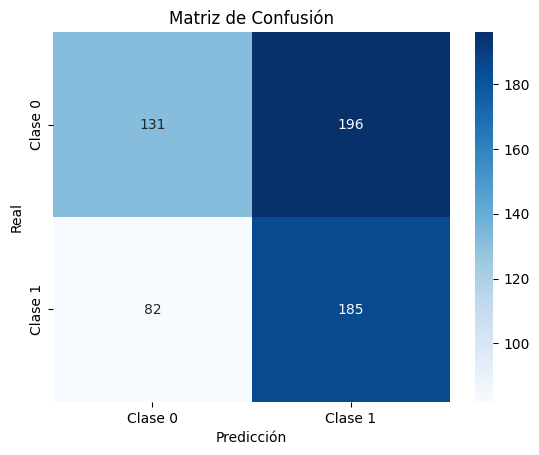

In [11]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Como vemos, con Grid Search el modelo no es bueno ya que ronda el 0.5 en métricas como el f1_score o el accuracy. No obstante, como previamente hemos dicho, este no era el objetivo del modelo. Vamos a probar con Random Search.

In [35]:
def train_decision_tree_random(X_train, y_train, X_test, y_test):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir modelo base
    dt2 = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3],
    "min_samples_split": [int(x) for x in np.arange(2, 20, 2)],
    "min_samples_leaf": [int(x) for x in np.arange(1, 20, 2)],
    'min_weight_fraction_leaf': [0.10, 0.12, 0.14],
    'splitter': ['best'],
    "max_features": ["sqrt", "log2", None],
    'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
    'min_impurity_decrease': [0,0.0001,0.001]
    }

    #  ['ccp_alpha','max_leaf_nodes',
    #  'min_weight_fraction_leaf', 'monotonic_cst', 'random_state']  otros posibles parámetros

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=dt2,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_test)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(15, 8))
    plot_tree(random_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return random_search.best_estimator_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.12, 'min_samples_split': 10, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': {np.False_: np.float64(0.8897224306076519), np.True_: np.float64(1.1414821944177094)}}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.40      0.49       327
        True       0.49      0.69      0.57       267

    accuracy                           0.53       594
   macro avg       0.55      0.55      0.53       594
weighted avg       0.56      0.53      0.52       594



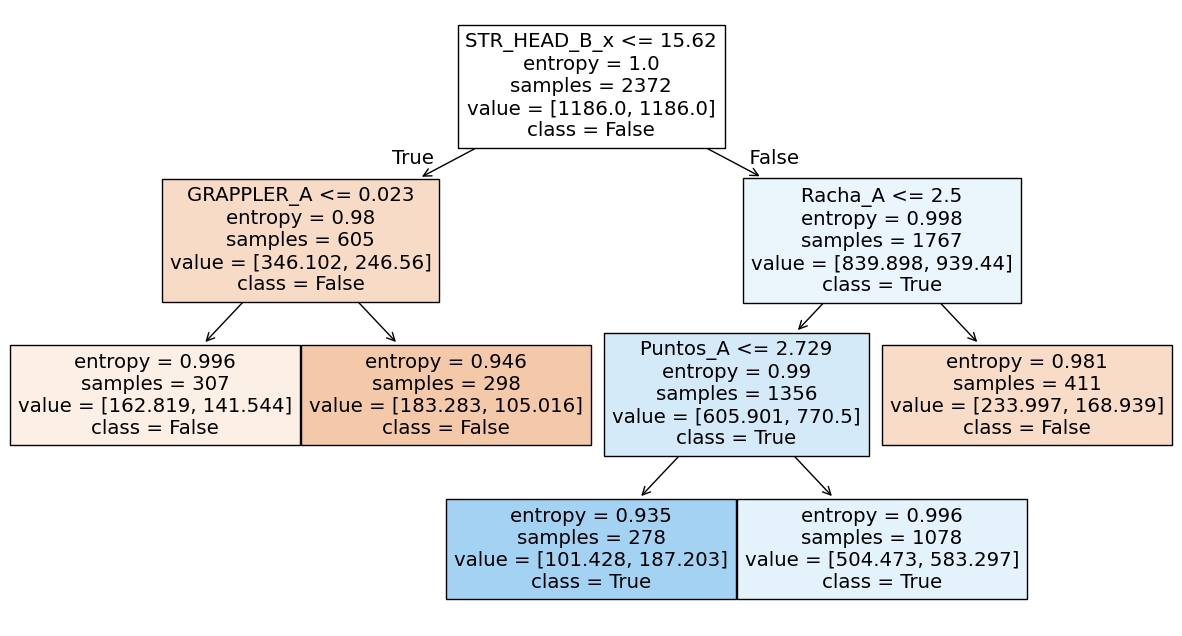

In [36]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
tree2 = train_decision_tree_random(X_train,y_train,X_test,y_test)

Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.34335
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.09526
Variables con importancia en el modelo: Racha_A, Importancia: 0.37927
Variables con importancia en el modelo: Puntos_A, Importancia: 0.18212


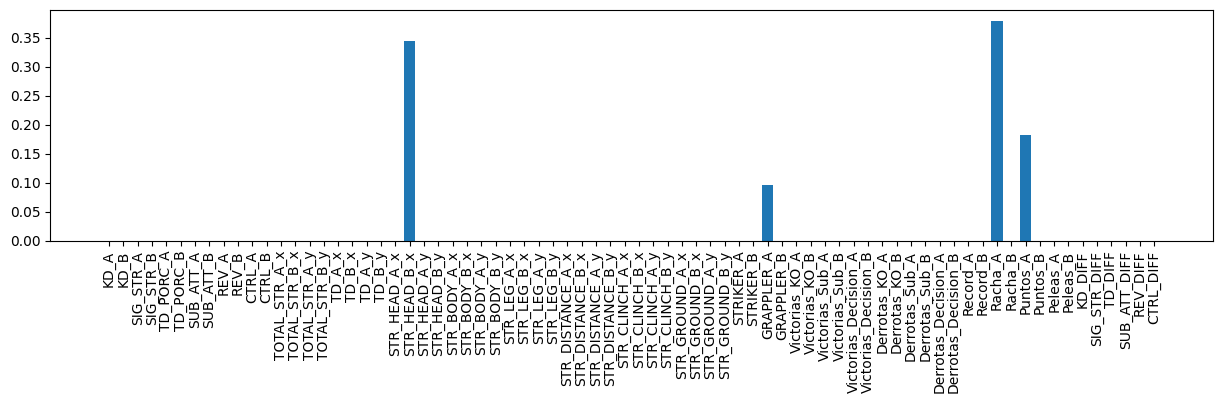

In [37]:
importance = tree2.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

In [38]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_test_pred = tree2.predict(X_test)
y_test_prob = tree2.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_prob)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
log_loss_test = log_loss(y_test,y_test_prob)

print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test, y_test_pred))



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.531986531986532
F1-Score: 0.5710
AUC-ROC: 0.5674
Precisión: 0.4856
Sensibilidad: 0.6929
Log-loss: 0.6847063263630556
[[131 196]
 [ 82 185]]


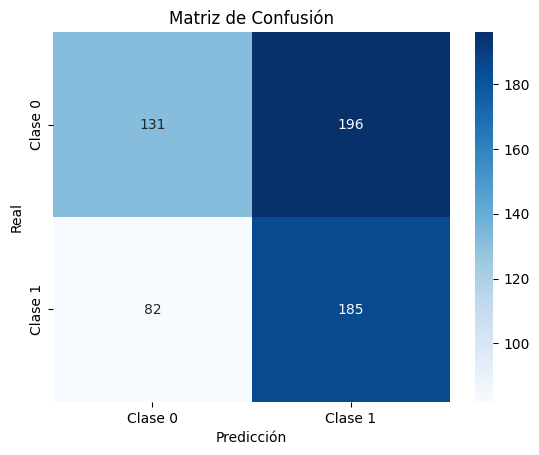

In [16]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo con Random Search es casi idéntico al realizado con Grid Search anteriormente.